# Plot time series of speed, PDDs, and terminus retreat, fit linear models to peaks 

In [1]:
import xarray as xr
import rioxarray as rxr
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import geopandas as gpd
import scipy
from sklearn.linear_model import LinearRegression
import seaborn as sns

## Load datasets

In [2]:
data_path = '/Users/raineyaberle/Research/Hubbard/'
out_path = '/Users/raineyaberle/Research/Hubbard/figures/'
crs = 'EPSG:3338'

# -----Velocity
ds_fn = os.path.join(data_path, 'velocity', 'Hubbard_S1.nc')
ds = xr.load_dataset(ds_fn)
ds["v"] = np.sqrt(ds.vx**2 + ds.vy**2).fillna(0)
ds["month"] = ds.time.dt.month
ds["year"] = ds.time.dt.year
ds["doy"] = ds.time.dt.dayofyear
ds = ds.rio.write_crs('EPSG:3413')
ds = ds.rio.reproject(crs)
ds = xr.where(ds > 1e10, np.nan, ds)
ds = xr.where(ds==0, np.nan, ds)
ds = ds.rio.write_crs(crs)
print('Velocities loaded')

# -----Air temperature --> PDDs
air_fn = os.path.join(data_path, 'weather', 'Yakutat_2000_2023.csv')
air = pd.read_csv(air_fn)
# remove empty columns
air = air[[x for x in list(air.columns) if 'Unnamed' not in x]]
air['Date_Time'] = pd.DatetimeIndex(air['Date_Time'])
air.rename(columns={'Date_Time': 'Date'}, inplace=True)
print('Weather loaded')

# -----Terminus sections
term_sect_fn = os.path.join(data_path, 'terminus', 'terminus_sections.gpkg')
term_sect = gpd.read_file(term_sect_fn)
term_sect = term_sect.to_crs(crs)
print('Terminus sections loaded')

# -----Terminus
term_fn = os.path.join(data_path, 'terminus', 'terminus_position_smooth.csv')
term = pd.read_csv(term_fn)
term['Date'] = pd.to_datetime(term['Date'])
term.drop_duplicates(inplace=True)
term['Mean_position_m'] = term[['section_A [m]', 'section_B1 [m]', 'section_B2 [m]', 'section_C [m]']].mean(axis=1)
term['Mean_position_section_B_m'] = term[['section_B1 [m]', 'section_B2 [m]']].mean(axis=1)
# Calculate the negative to measure retreat as positive
term['Mean_retreat_m'] = -term['Mean_position_m']
term['Mean_retreat_section_B_m'] = -term['Mean_position_section_B_m']
# Resample to daily
term.set_index('Date', inplace=True)
term = term.resample('1D').interpolate('time')
term.reset_index(inplace=True)
# Calculate mean retreat rate [m/d]
term['Mean_retreat_rate_m/d'] = term['Mean_retreat_m'].diff()
print('Terminus positions loaded')


Velocities loaded
Weather loaded
Terminus sections loaded
Terminus positions loaded


## Sample speeds at each terminus section, average

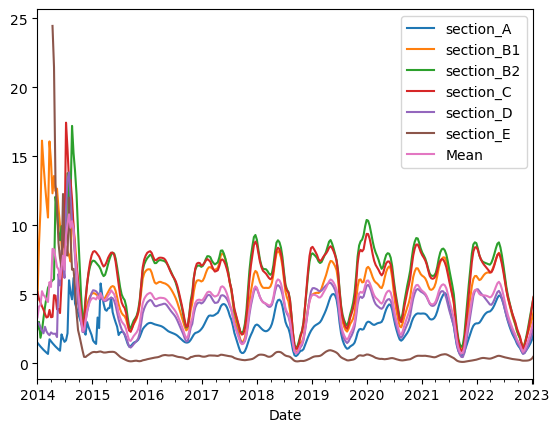

In [3]:
# Calculate mean speeds in each section
v_term = pd.DataFrame(columns=['Date'] + list(term_sect['section'].values))
v_term['Date'] = ds.time.data
for i in range(0,len(term_sect)):
    term_sect_i = term_sect.iloc[i,:]
    # Clip velocity to terminus section
    v_samp = ds.rio.clip([term_sect_i.geometry])
    # Average the timeseries in the polygon
    v_samp_mean = v_samp.mean(dim='x').mean(dim='y').v.data
    # Add to dataframe
    v_term[term_sect_i['section']] = v_samp_mean

# Calculate mean time series in all terminus sections
v_term.set_index('Date', inplace=True)
v_term['Mean'] = v_term.mean(axis=1)
v_term = v_term / 365 # Convert from m/y to m/d
v_term.plot()
v_term.reset_index(inplace=True)

In [4]:
## Calculate annual peaks
# Add fake year columns (starting in April)
def add_fake_year_column(df):
    def calculate_fake_year(month, year):
        if month < 4:
            return year-1
        else:
            return year
    months, years = df['Date'].dt.month.values, df['Date'].dt.year.values
    df['fake_year'] = [calculate_fake_year(month, year) 
                        for month, year in list(zip(months, years))]
    return df
def subset_fake_years_add_color(df):
    df = df.loc[(df['fake_year'] >= 2017) & (df['fake_year'] <= 2022)]
    df['color'] = [plt.cm.viridis(i/5) for i in range(0,len(df))]
    return df

# PDDs
air = add_fake_year_column(air)
air['fake_year'] = air['fake_year'] + 1
def calculate_pdd(temp):
    if temp > 0:
        return temp
    else:
        return 0
air['PDD'] = air['air_temp_set_1'].apply(calculate_pdd)
air['cumulative_PDD'] = air.groupby(air['Date'].dt.year)['PDD'].cumsum()
ipeaks = air.groupby(air['fake_year'])['cumulative_PDD'].idxmax().values
pdd_peaks = air.loc[ipeaks, ['Date', 'cumulative_PDD', 'fake_year']].reset_index(drop=True)
pdd_peaks = subset_fake_years_add_color(pdd_peaks)
# Terminus retreat
term = add_fake_year_column(term)
ipeaks = term.groupby(term['fake_year'])['Mean_retreat_m'].idxmax()
term_peaks = term.loc[ipeaks, ['Date', 'Mean_retreat_m', 'fake_year']].reset_index(drop=True)
term_peaks = subset_fake_years_add_color(term_peaks)
# Summer speed peaks
v_term = add_fake_year_column(v_term)
v_term_summer = v_term.loc[(v_term['Date'].dt.month >= 4) & ((v_term['Date'].dt.month <= 6))]
ipeaks = v_term_summer.groupby(v_term_summer['fake_year'])['Mean'].idxmax().values
v_summer_peaks = v_term_summer.loc[ipeaks, ['Date', 'Mean', 'fake_year']].reset_index(drop=True)
v_summer_peaks = subset_fake_years_add_color(v_summer_peaks)
# Winter speed peaks
v_term_winter = v_term.loc[(v_term['Date'].dt.month > 10) | ((v_term['Date'].dt.month < 2))]
ipeaks = v_term_winter.groupby(v_term_winter['fake_year'])['Mean'].idxmax().values
v_winter_peaks = v_term_winter.loc[ipeaks, ['Date', 'Mean', 'fake_year']].reset_index(drop=True)
v_winter_peaks = subset_fake_years_add_color(v_winter_peaks)

# Merge into one dataframe for regression plotting
peaks_merged = (pdd_peaks[['fake_year', 'color', 'cumulative_PDD']].merge(
    term_peaks[['fake_year', 'Mean_retreat_m']].merge(
        v_summer_peaks[['fake_year', 'Mean']].merge(
            v_winter_peaks[['fake_year', 'Mean']], on='fake_year', how='outer', suffixes=['_summer_peak', '_winter_peak']),
        on='fake_year', how='outer'),
    on='fake_year', how='outer'))
peaks_merged

/var/folders/9h/sg2rw9f10lq5jmfch9hnj6gc0000gq/T/ipykernel_10168/2045753011.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['color'] = [plt.cm.viridis(i/5) for i in range(0,len(df))]
/var/folders/9h/sg2rw9f10lq5jmfch9hnj6gc0000gq/T/ipykernel_10168/2045753011.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['color'] = [plt.cm.viridis(i/5) for i in range(0,len(df))]
/var/folders/9h/sg2rw9f10lq5jmfch9hnj6gc0000gq/T/ipykernel_10168/2045753011.py:15: SettingWithCopyWarning: 
A value is trying to b

,fake_year,color,cumulative_PDD,Mean_retreat_m,Mean_summer_peak,Mean_winter_peak
0,2017,"(0.267004, 0.004874, 0.329415, 1.0)",2560.960717,200.286522,5.585071,5.579568
1,2018,"(0.253935, 0.265254, 0.529983, 1.0)",2247.619332,51.802420,6.086372,4.972716
2,2019,"(0.163625, 0.471133, 0.558148, 1.0)",2391.050994,130.550050,6.078034,6.008102
3,2020,"(0.134692, 0.658636, 0.517649, 1.0)",2641.913461,100.640109,5.272930,5.684175
4,2021,"(0.477504, 0.821444, 0.318195, 1.0)",2093.838591,69.035209,5.728345,5.332298
5,2022,"(0.993248, 0.906157, 0.143936, 1.0)",1965.187097,NaN,5.911291,3.073130


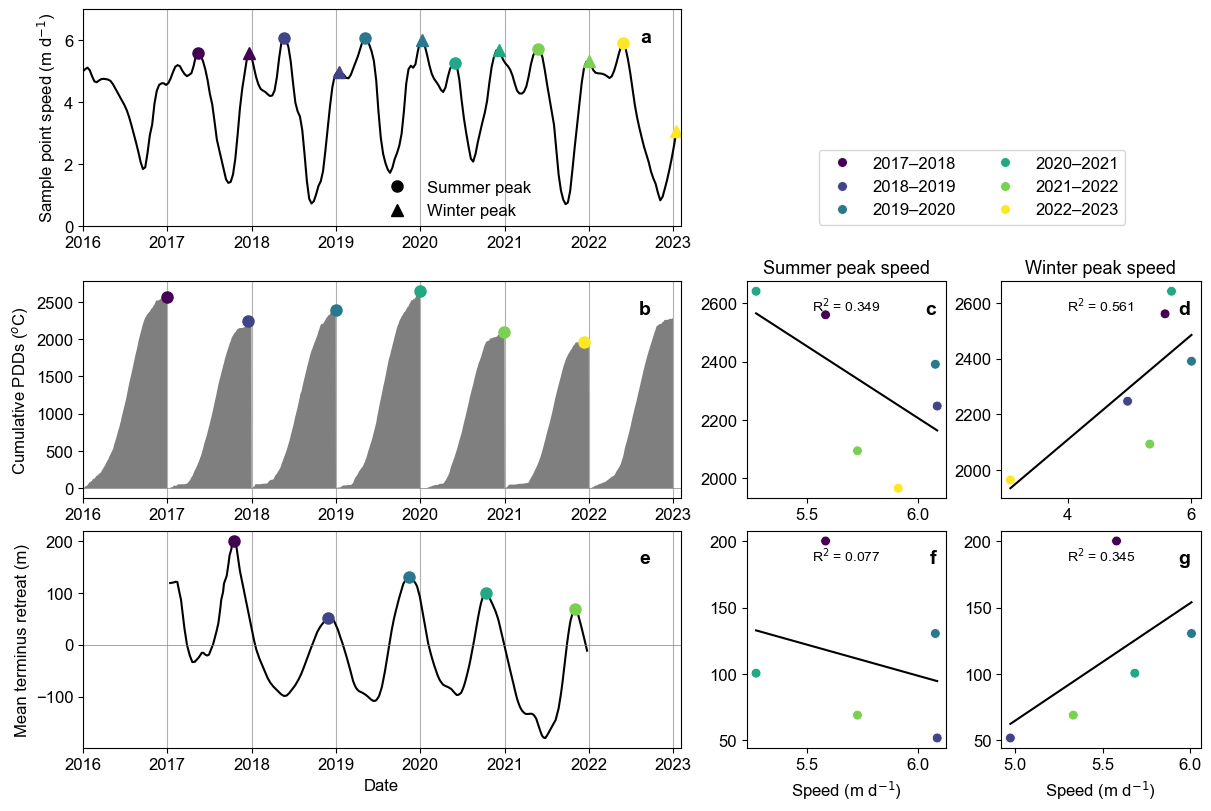

Figure saved to file: /Users/raineyaberle/Research/Hubbard/figures/speed_peaks_vs_PDD_terminus.png


In [5]:
## Plot time series
fontsize=12
markersize=8
plt.rcParams.update({'font.sans-serif': 'Arial', 'font.size': fontsize})
fig, ax = plt.subplots(3, 3, figsize=(12,8), gridspec_kw={'width_ratios': [3,1,1]}, constrained_layout=True)

# -----Time series
# Speed
ax[0,0].plot(v_term['Date'], v_term['Mean'], '-k')
for date, summer_peak, color in v_summer_peaks[['Date', 'Mean', 'color']].values:
    ax[0,0].plot(date, summer_peak, 'o', color=color, markersize=markersize)
for date, winter_peak, color in v_winter_peaks[['Date', 'Mean', 'color']].values:
    ax[0,0].plot(date, winter_peak, '^', color=color, markersize=markersize)
ax[0,0].plot(np.datetime64('2000-01-01'), 0, 'o', color='k', markersize=markersize, label='Summer peak')
ax[0,0].plot(np.datetime64('2000-01-01'), 0, '^', color='k', markersize=markersize, label='Winter peak')
handles, labels = ax[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', frameon=False, bbox_to_anchor=[0.25, 0.6, 0.2, 0.2])
ax[0,0].set_ylim(0,7)
ax[0,0].set_ylabel('Sample point speed (m d$^{-1}$)')
# PDDs
ax[1,0].fill_between(air['Date'], np.zeros(len(air)), air['cumulative_PDD'], 
                     facecolor='k', edgecolor=None, alpha=0.5)
for date, pdd, color in pdd_peaks[['Date', 'cumulative_PDD', 'color']].values:
    ax[1,0].plot(date, pdd, 'o', color=color, markersize=markersize)
ax[1,0].set_ylabel('Cumulative PDDs ($^o$C)')
# Terminus
ax[2,0].plot(term['Date'], term['Mean_retreat_m'], '-k')
for date, retreat, color in term_peaks[['Date', 'Mean_retreat_m', 'color']].values:
    ax[2,0].plot(date, retreat, 'o', color=color, markersize=markersize)
ax[2,0].set_ylabel('Mean terminus retreat (m)')
ax[2,0].set_xlabel('Date')
# adjust axes
xmin, xmax = np.datetime64('2016-01-01'), np.datetime64('2023-02-01')
for axis in ax[:,0]:
    axis.set_xlim(xmin, xmax)
    axis.xaxis.grid(True)
    axis.hlines(0, xmin, xmax, linewidth=0.5, color='grey')

# -----Peak regressions
def linear_fit(df):
    X, y = df.dropna().values[:,0], df.dropna().values[:,1]
    X = X.reshape(-1,1)
    lr = LinearRegression().fit(X,y)
    score = lr.score(X,y)
    Xpred = np.linspace(np.min(X), np.max(X), 100).reshape(-1,1)
    ypred = lr.predict(Xpred)
    return Xpred, ypred, score
def plot_score(axis, score):
    axis.text(0.5, 0.86, f'R$^2$ = {np.round(score,3)}', transform=axis.transAxes, ha='center', fontsize=fontsize-2)
    return
# PDD-summer
sns.scatterplot(data=peaks_merged, x='Mean_summer_peak', y='cumulative_PDD', hue='fake_year', 
                palette=dict(peaks_merged[['fake_year', 'color']].values), s=50, ax=ax[1,1]) 
Xpred, ypred, score = linear_fit(peaks_merged[['Mean_summer_peak', 'cumulative_PDD']])
ax[1,1].plot(Xpred, ypred, '-k')
plot_score(ax[1,1], score)
ax[1,1].set_xlabel('')
ax[1,1].set_ylabel('')
ax[1,1].set_title('Summer peak speed', fontsize=fontsize+1)
# Add legend for years
handles, labels = ax[1,1].get_legend_handles_labels()
ax[1,1].legend().remove()
labels = ['2017–2018', '2018–2019', '2019–2020', '2020–2021', '2021–2022', '2022–2023']
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=[0.74, 0.63, 0.2, 0.2], ncols=2)
# PDD-winter
sns.scatterplot(data=peaks_merged, x='Mean_winter_peak', y='cumulative_PDD', hue='fake_year', 
                palette=dict(peaks_merged[['fake_year', 'color']].values), s=50, legend=False, ax=ax[1,2]) 
Xpred, ypred, score = linear_fit(peaks_merged[['Mean_winter_peak', 'cumulative_PDD']])
ax[1,2].plot(Xpred, ypred, '-k')
plot_score(ax[1,2], score)
ax[1,2].set_xlabel('')
ax[1,2].set_ylabel('')
ax[1,2].set_title('Winter peak speed', fontsize=fontsize+1)
# Term-summer
sns.scatterplot(data=peaks_merged, x='Mean_summer_peak', y='Mean_retreat_m', hue='fake_year', 
                palette=dict(peaks_merged[['fake_year', 'color']].values), s=50, legend=False, ax=ax[2,1]) 
Xpred, ypred, score = linear_fit(peaks_merged[['Mean_summer_peak', 'Mean_retreat_m']])
ax[2,1].plot(Xpred, ypred, '-k')
plot_score(ax[2,1], score)
ax[2,1].set_ylabel('')
ax[2,1].set_xlabel('Speed (m d$^{-1}$)')
# Term-winter
sns.scatterplot(data=peaks_merged, x='Mean_winter_peak', y='Mean_retreat_m', hue='fake_year', 
                palette=dict(peaks_merged[['fake_year', 'color']].values), s=50, legend=False, ax=ax[2,2]) 
Xpred, ypred, score = linear_fit(peaks_merged[['Mean_winter_peak', 'Mean_retreat_m']])
ax[2,2].plot(Xpred, ypred, '-k')
plot_score(ax[2,2], score)
ax[2,2].set_ylabel('')
ax[2,2].set_xlabel('Speed (m d$^{-1}$)')

# Add panel labels
def plot_panel_label(axis, label):
    axis.text(0.95, 0.85, label, transform=axis.transAxes,
              ha='right', fontweight='bold', fontsize=fontsize+2)
    return
labels = ['a', 'b', 'c', 'd', 'e', 'f', 'g']
for axis, label in list(zip([ax[0,0], 
                             ax[1,0], ax[1,1], ax[1,2],
                             ax[2,0], ax[2,1], ax[2,2]], labels)):
    plot_panel_label(axis, label)

# Remove unused axes
ax[0,1].remove()
ax[0,2].remove()

# fig.tight_layout()
plt.show()

# Save figure
fig_fn = os.path.join(out_path, 'speed_peaks_vs_PDD_terminus.png')
fig.savefig(fig_fn, dpi=300, bbox_inches='tight')
print('Figure saved to file:', fig_fn)